# Customer Churn Prediction


## The Dataset

Long-standing telecom consumer data set.

The information is straightforward. Each row represents a telephone subscriber. Each column comprises customer information such as phone number, call minutes used at various times of day, service prices, lifetime account duration, and whether or not the customer is still a customer.

1. State: the US state in which the customer resides, indicated by a two-letter abbreviation
2. Account Length: the number of days that this account has been active
3. Area Code: the three-digit area code of the corresponding customer’s phone number
4. Phone: the remaining seven-digit phone number
5. Int’l Plan: whether the customer has an international calling plan: yes/no
6. VMail Plan: whether the customer has a voice mail feature: yes/no
7. VMail Message: presumably the average number of voice mail messages per month
8. Day Mins: the total number of calling minutes used during the day
9. Day Calls: the total number of calls placed during the day
10. Day Charge: the billed cost of daytime calls
11. Eve Mins: the total number of calling minutes used during the evening
12. Eve Calls: the total number of calls placed during the evening
13. Eve Charge: the billed cost of evening time calls
14. Night Mins: the total number of calling minutes used during the night
15. Night Calls: the total number of calls placed during the night
16. Night Charge: the billed cost of nighttime calls
17. Intl Mins: the total number of international minutes
18. Intl Calls: the total number of international calls
19. Intl Charge: the billed cost for international calls
20. CustServ Calls: the number of calls placed to Customer Service
21. Churn?: whether the customer left the service: true/false

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import KFold

from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve

c:\Users\juani\anaconda3\envs\env1\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Read file
churn_df = pd.read_csv('./churn.csv')

# Exploratory Data Analysis & Data Cleaning

In [3]:
# Overview of data
churn_df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [4]:
# Check Columns Names, Data types, Null values
churn_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [5]:
# Rename churn column
churn_df = churn_df.rename(columns={'Churn?': 'Churn'})


In [6]:
# Check the amount of users with churn == True. and False.
churn_df['Churn'].value_counts(normalize=True)


False.    0.855086
True.     0.144914
Name: Churn, dtype: float64

Unbalanced dataset! 85% of the customers are still with the company. This is a problem for classification models. We will need to balance the dataset.

In [7]:
# What categorical data do we have?
catagorical = [i for i in churn_df.columns if churn_df[i].dtypes == 'object']

for i in catagorical:   
    print(i, ':', churn_df[i].unique())

State : ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']
Phone : ['382-4657' '371-7191' '358-1921' ... '328-8230' '364-6381' '400-4344']
Int'l Plan : ['no' 'yes']
VMail Plan : ['yes' 'no']
Churn : ['False.' 'True.']


<AxesSubplot:xlabel='State'>

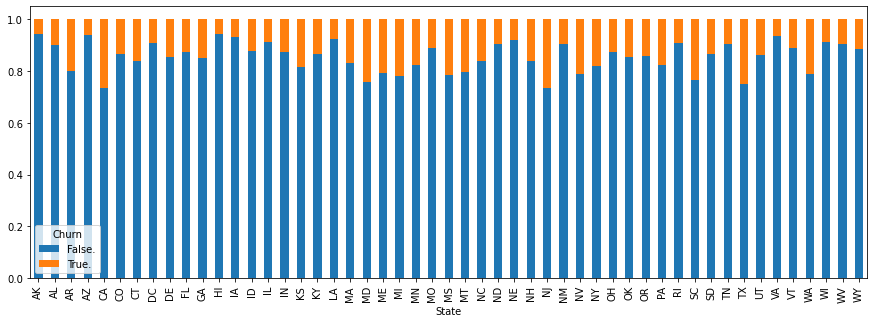

In [8]:
# Plot the churn rate for each state
churn_df.groupby('State')['Churn'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(15, 5))

We will drop the phone number column as it is not useful for our analysis, as well as the state column and the area code. Churn columns is our target variable, so we will drop it from the features. In addition, Int'l Plan and VMail Plan are categorical variables, so we will convert them to binary numerical values.

State columns is removed for simplicity, but could be useful for further analysis.


In [9]:
# Drop unwanted columns
to_drop = ['State','Area Code','Phone','Churn']
churn_features = churn_df.drop(to_drop,axis=1)

In [10]:
# Convert 'Yes' and 'No' columns to 1 and 0 columns
yes_no_cols = ["Int'l Plan","VMail Plan"]

# If the value is yes, make it 1, otherwise 0
churn_features[yes_no_cols] = churn_features[yes_no_cols] == 'yes'

churn_df['Churn'] = churn_df['Churn'].map({'True.': 1, 'False.': 0})
churn_features_and_target = churn_features.join(churn_df['Churn'])


In [11]:
# Isolate target data
y = churn_result = churn_df['Churn'].to_numpy()


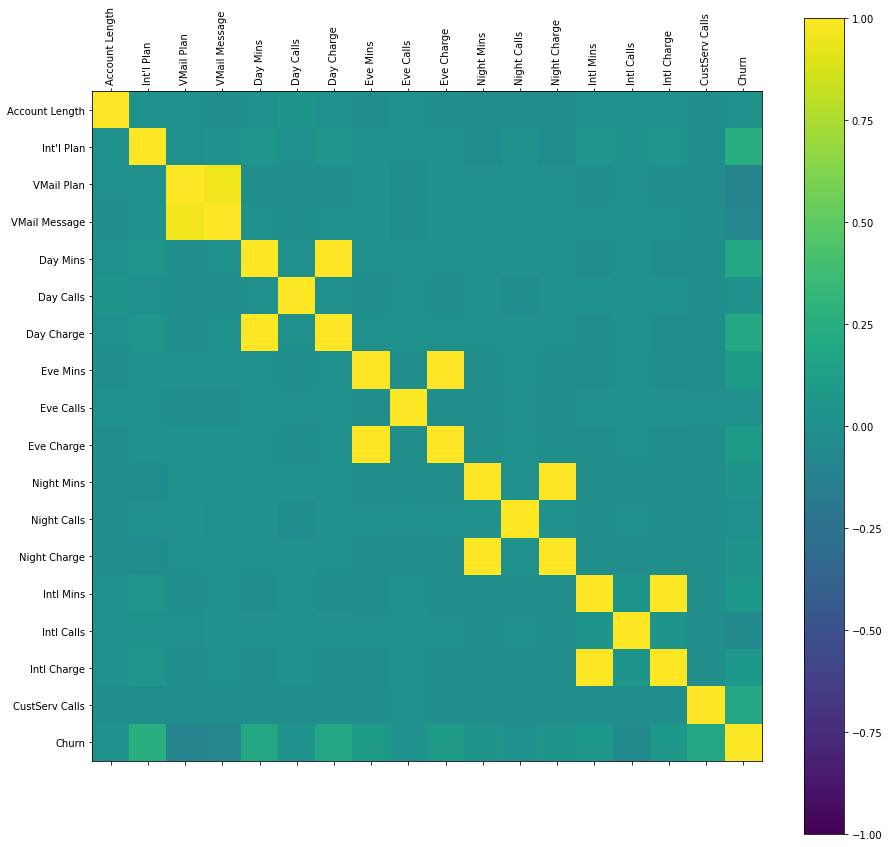

In [12]:
# Plot the correlation matrix
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(churn_features_and_target.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(churn_features_and_target.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(churn_features_and_target.columns)
ax.set_yticklabels(churn_features_and_target.columns)
plt.show()


Nothing too surpising here. The main correlation appears between minutes and charges. This is expected. The other correlations are not very strong. We will keep all the features for now.

In [13]:
# List of features
features = churn_features.columns
print(features)

Index(['Account Length', 'Int'l Plan', 'VMail Plan', 'VMail Message',
       'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls',
       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins',
       'Intl Calls', 'Intl Charge', 'CustServ Calls'],
      dtype='object')


In [14]:
# To numpy array
X = churn_features.to_numpy().astype(float)


# Standard Scaler application
# We need to scale the data so that all the features are treated equally when applying the models.
scaler = StandardScaler()
X = scaler.fit_transform(X)

features_number = X.shape[1]
observations_number = X.shape[0]

print(f"There are {features_number} features and {observations_number} observations in the dataset.")

# Must be a binary classification problem (0 or 1)
print("Unique target labels:", np.unique(y))
      

There are 17 features and 3333 observations in the dataset.
Unique target labels: [0 1]


In [15]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Over-sampling with SMOTE
SMOTE: Synthetic Minority Over-sampling Technique SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

In [16]:
x_smote, y_smote = SMOTE().fit_resample(X_train, y_train)

### Under-sampling with NearMiss3

Under-sampling . NearMiss3: When instances of two different classes are very close to each other, it removes the instances of the majority class to increase the spaces between the two classes. It works in 2 steps: Firstly, for each minority class instance, their M nearest-neighbors will be stored. Then finally, the majority class instances are selected for which the average distance to the N nearest-neighbors is the largest.

In [17]:
x_nearmiss, y_nearmiss = NearMiss(version=3).fit_resample(X_train, y_train)

### Comparing algorithms

In [18]:
# Custom cross validation function
def run_cv(X,y,clf_class,type='none',**kwargs):
    # Construct a kfolds object
    kf = KFold(n_splits=5,shuffle=True)
    y_pred = y.copy()

    
    # Iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]

        # Apply resampling
        if type == 'smote':
            X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        elif type == 'nearmiss':
            X_train, y_train = NearMiss(version=3).fit_resample(X_train, y_train)

        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [25]:
classifiers = []
classifiers.append({"Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced')})
classifiers.append({"Random Forest": RandomForestClassifier(class_weight='balanced')})
classifiers.append({"SVM": SVC(C = 10,class_weight='balanced', probability=True)})
classifiers.append({"KNN": KNeighborsClassifier(n_neighbors=5)})
classifiers.append({"XGBoost": xgb.XGBClassifier(eval_metric = 'logloss',use_label_encoder=False)})

# deactivate warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# General df to store the classification report for all the models
solution_df = pd.DataFrame()


for s_type in ['none','smote','nearmiss']:
    for class_instance in classifiers:
        name = list(class_instance.keys())[0]
        classifier = list(class_instance.values())[0]

        scores = cross_validate(classifier, X, y, scoring=["accuracy","precision","recall","f1"],cv=5)
        y_pred = run_cv(X,y,classifier.__class__,type=s_type)
        
        # Classification report in dictionary format
        report_dict = classification_report(y, y_pred, output_dict=True)
        
        # Convert the dictionary to a dataframe
        report_df = pd.DataFrame(report_dict).transpose()

        # Add classifier name to the report
        report_df['Classifier'] = name

        # Add the resampling type to the report
        report_df['Resampling'] = s_type

        # Add the report to the general df
        solution_df = pd.concat([solution_df, report_df])



        # Round the scores to 3 decimal places if value is float, else leave it as it is
        # scores_dict = {k: round(v, 3) if isinstance(v, float) else v for k, v in scores_dict.items()}


    

# Set classifier + resampling as index
solution_df = solution_df.set_index(['Classifier','Resampling'])


# Group by classifier and resampling and take the mean of the scores
solution_df = solution_df.groupby(['Classifier','Resampling']).mean()
solution_df





[19:59:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:59:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:59:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:59:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

precision    recall  f1-score      support
Classifier          Resampling                                            
KNN                 nearmiss     0.709311  0.743603  0.710357  1999.955476
                    none         0.861691  0.761660  0.785448  1999.978698
                    smote        0.750230  0.799037  0.757616  1999.963096
Logistic Regression nearmiss     0.696770  0.730609  0.691910  1999.950915
                    none         0.755220  0.692617  0.698941  1999.971437
                    smote        0.719736  0.766503  0.716144  1999.954155
Random Forest       nearmiss     0.825548  0.876993  0.842515  1999.977678
                    none         0.954605  0.902337  0.924005  1999.991299
                    smote        0.917374  0.913343  0.915328  1999.989559
SVM                 nearmiss     0.809372  0.840090  0.821290  1999.975818
                    none         0.918029  0.817463  0.848066  1999.984218
                    smote        0.848764  0.864876  0.856110  1999.981458
XGBoost             nearmiss     0.802395  0.858194  0.817716  1999.973357
                    none         0.946135  0.908818  0.925130  1999.991239
                    smote        0.935420  0.912916  0.923278  1999.990819

The models are biased towards the majority class because the dataset is unbalanced. The relevant scoring metric for unbalanced data is the F1 score. The F1 score is the harmonic mean of precision and recall. It is a good measure of a test’s accuracy. It is also a good measure of a model’s robustness. If there is an uneven class distribution, it is better to use the F1 score than accuracy, precision, or recall. Based on the F1 score, the best models are the Random Forest Classifier and the XGBoost Classifier.


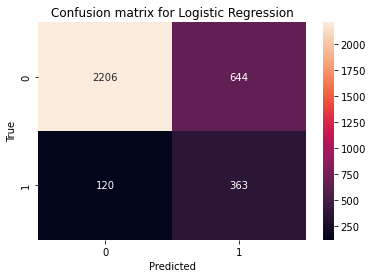

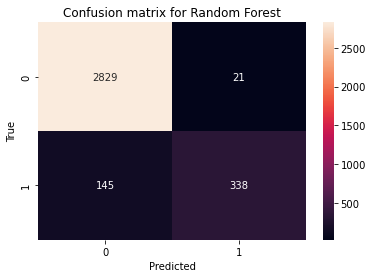

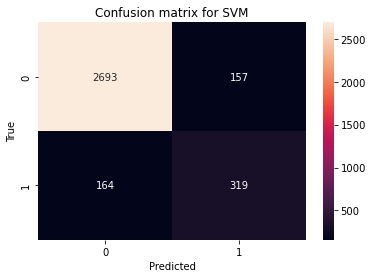

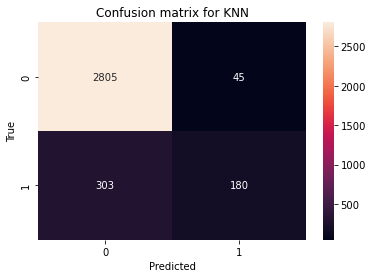

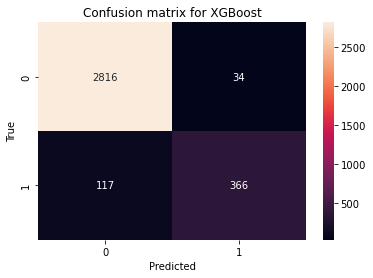

In [34]:
def draw_confusion_matrices(confusion_matricies):
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        sns.heatmap(cm, annot=True,fmt='g' , ax=ax);
        plt.title('Confusion matrix for %s' % classifier)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)


confusion_matrices = []
for class_instance in classifiers:
    name = list(class_instance.keys())[0]
    classifier = list(class_instance.values())[0]

    y_pred = cross_val_predict(classifier, X, y, cv=5)
    cm = confusion_matrix(y, y_pred)
    confusion_matrices.append((name, cm))


draw_confusion_matrices(confusion_matrices)


From the confusion matrices above and the F1 scores of the models, we can see that the Random Forest model and the XGBoost model perform the best.

## ROC Plots & Precision-Recall Curves


The ROC plot is a popular and powerful measure to evaluate binary classifiers. Nonetheless, it has some limitations when applied to imbalanced datasets. Other plots, such as CROC and precision-recall, are less frequently used than ROC. Our simulation analysis indicates that only the precision-recall plot changes depending on the ratio of positives and negatives, and it is also more informative than the ROC plot when applied to imbalanced datasets.

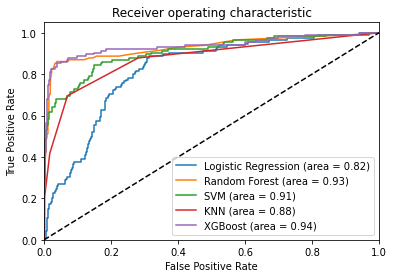

In [35]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# Calculate and plot ROC curve for each classifier
def plot_roc_curve(classifiers, X_test, y_test):
    for class_instance in classifiers:
        name = list(class_instance.keys())[0]
        classifier = list(class_instance.values())[0]

        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (name, roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(classifiers, X_test, y_test)

    

c:\Users\juani\anaconda3\envs\env1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\juani\anaconda3\envs\env1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\juani\anaconda3\envs\env1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecate

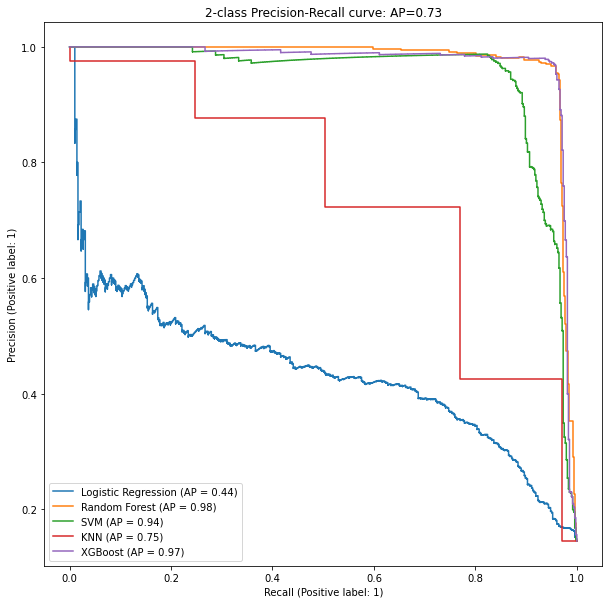

In [36]:
def plot_precision_recall(X, y,classifier_list, **kwargs):
    # Plot Precision-Recall curves for each classifier in the same figure
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)

    for class_instance in classifier_list:
        name = list(class_instance.keys())[0]
        classifier = list(class_instance.values())[0]
        y_pred = cross_val_predict(classifier, X, y, cv=5)
        average_precision = average_precision_score(y, y_pred)
        disp = plot_precision_recall_curve(classifier, X, y, ax=ax, name=name)
        disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()


plot_precision_recall(X,y, classifiers)



## Feature Importance

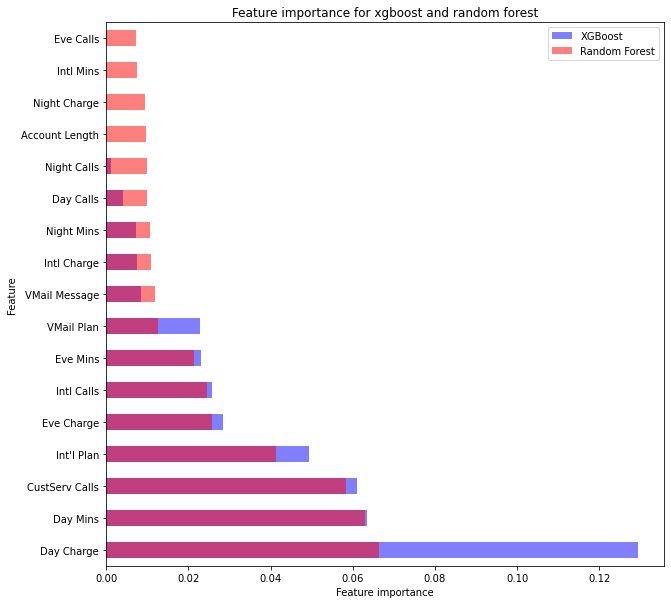

In [37]:
# Get XGBoost and random forest from the classifiers list
for class_instance in classifiers:
    name = list(class_instance.keys())[0]
    classifier = list(class_instance.values())[0]
    if name == 'XGBoost':
        xgb_model = classifier
    elif name == 'Random Forest':
        rf_model = classifier

# xgboost
xgb_model.fit(X_train, y_train)
xgb_importance = permutation_importance(xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
xgb_importance_df = pd.DataFrame(xgb_importance.importances_mean, index=features, columns=['importance']).sort_values('importance', ascending=False)
xgb_importance_df


# random forest
rf_model.fit(X_train, y_train)
rf_importance = permutation_importance(rf_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
rf_importance_df = pd.DataFrame(rf_importance.importances_mean, index=features, columns=['importance']).sort_values('importance', ascending=False)
rf_importance_df


# Plot the feature importance for xgboost and random forest in the same figure
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
xgb_importance_df.plot(kind='barh', ax=ax, color='b', alpha=0.5, legend=True)
rf_importance_df.plot(kind='barh', ax=ax, color='r', alpha=0.5, legend=True)
ax.legend(['XGBoost', 'Random Forest'])
ax.set_title('Feature importance for xgboost and random forest')
ax.set_xlabel('Feature importance')
ax.set_ylabel('Feature')
plt.show()





# Probability Calibration


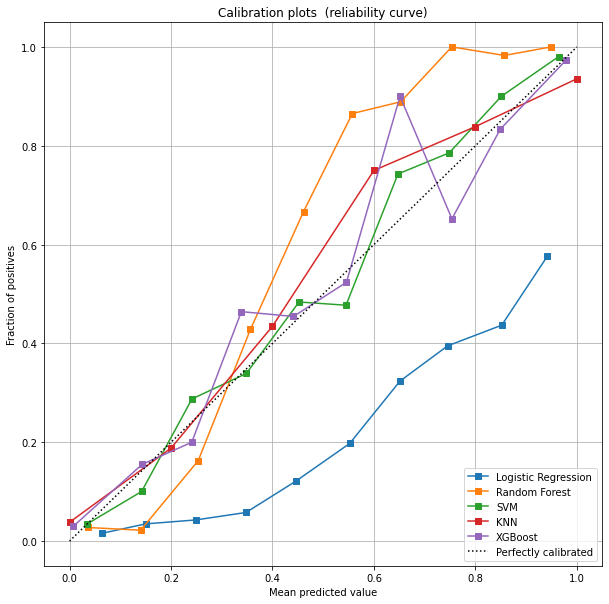

In [38]:
def plot_calibration_curve(X, y, classifier_list, **kwargs):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)

    for class_instance in classifier_list:
        name = list(class_instance.keys())[0]
        classifier = list(class_instance.values())[0]
        y_pred = cross_val_predict(classifier, X, y, cv=5, method='predict_proba')[:,1]
        fraction_of_positives, mean_predicted_value = calibration_curve(y, y_pred, n_bins=10)
        ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=name)
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax.set_ylabel("Fraction of positives")
    ax.set_xlabel("Mean predicted value")
    ax.set_title('Calibration plots  (reliability curve)')
    ax.legend(loc="lower right")

    # Make the plot nicer
    ax.grid(True)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    
    plt.show()

plot_calibration_curve(X, y, classifiers)
